# Phase Response in directed Human Brain Connectome

In [197]:
import sys
import importlib

sys.path.append("../")

from src import utils
from src.utils import *

from src import plot_surf
from src import operations
from src import graph_utils
from src import jordanzero_destroy

import nibabel as nib

import scienceplots
plt.style.use(['science','ieee', 'no-latex'])

# for better visualisation of graphs. Comment out if not needed
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['figure.figsize'] = [3, 2]

## Description

Phase response in directed human brain connectome

GOAL: Analyse phase profile of consecutive timepoints (after peak) in rstfMRI

## Table of Contents
- [Phase Profile in fMRI](#phase-profile)

In [2]:
data_path = '../resources/'

## Phase Profile in fMRI

In [230]:
package = utils.load(utils.op.join(data_path, 'brain_directed_graph/bin_directed_connectome_ftract+structural-d50+metadata.pkl'))
A, roi_atlas, region_labels = package['struct'], package['atlas'], package['regionnames']

nb_nodes = A.shape[0]

A = operations.normalize_adjacency(A)
L, U, V, Uinv, _, _, _ = graph_utils.prep_transform(A, gso="laplacian")

ftimecourse = nib.load('../../atlas_data/moviedata_fMRI_eg/movie_group_fmri.nii').get_fdata()
atlas_data, affine = roi_atlas.get_fdata(), roi_atlas.affine

nb_time = ftimecourse.shape[-1]

Method chosen is: eig


In [231]:
# now we need to get the rest fmri and map it onto the roi to have timecourses
roi_indexes = np.arange(1, 84)

roi_timecourses = np.zeros((len(roi_indexes), ftimecourse.shape[3]))
for ridx in roi_indexes:
    roi_timecourses[ridx-1] = ftimecourse[atlas_data == ridx].mean(axis=0)

#### Global Strength (frame selection to phase response)

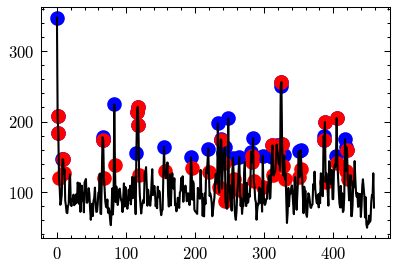

In [232]:
global_strength = np.linalg.norm(roi_timecourses, axis=0)

threshold = np.quantile(global_strength, 0.9)
above_thresh = np.where(global_strength > threshold)[0]

next_indexes = above_thresh + 1
assert next_indexes.max() < nb_time

avg_signal = roi_timecourses[:, above_thresh].mean(axis=1)
avg_signal_next = roi_timecourses[:, next_indexes].mean(axis=1)

plt.plot(global_strength)
plt.scatter(above_thresh, global_strength[above_thresh], color='blue')
plt.scatter(next_indexes, global_strength[next_indexes], color='red')

In [233]:
current_spectrum = operations.GFT(avg_signal, U, Uinv=Uinv)
next_spectrum = operations.GFT(avg_signal_next, U, Uinv=Uinv)

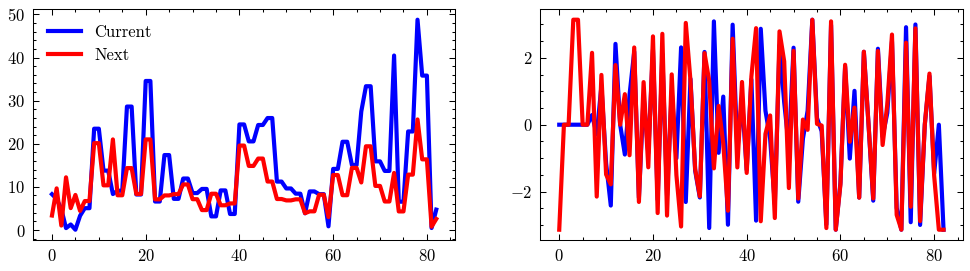

In [234]:
# Check profile spectrum amplitude of signal
fig, ax = plt.subplots(1, 2, figsize=(8,2))
ax[0].plot(np.abs(current_spectrum), label='Current', color='blue', linewidth=2)
ax[0].plot(np.abs(next_spectrum), label='Next', color='red', linestyle='solid', linewidth=2)
ax[0].legend()

# Check profile changes in angle
ax[1].plot(np.angle(current_spectrum), label='Current', color='blue', linewidth=2)
ax[1].plot(np.angle(next_spectrum), label='Next', color='red', linestyle='solid', linewidth=2)

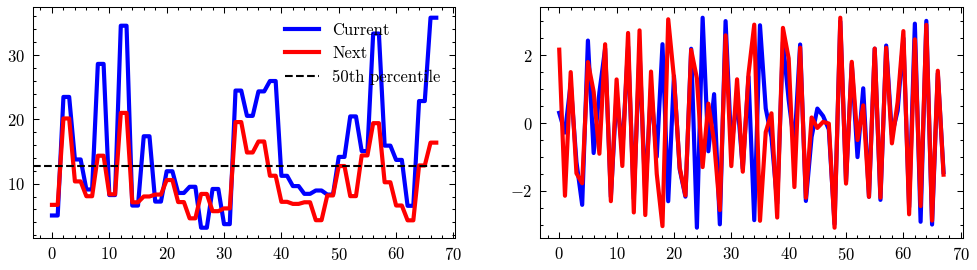

In [235]:
angles_idx = V.imag != 0

fig, ax = plt.subplots(1, 2, figsize=(8,2))

cur_soi = current_spectrum[angles_idx]
next_soi = next_spectrum[angles_idx]

cutoff = 0.5
ax[0].plot(np.abs(cur_soi), label='Current', color='blue', linewidth=2)
ax[0].plot(np.abs(next_soi), label='Next', color='red', linestyle='solid', linewidth=2)
ax[0].axhline(y=np.quantile(np.abs(cur_soi), cutoff), linestyle='--', color='k', label=f'{int(cutoff * 100)}th percentile')
ax[0].legend()

# Check profile changes in angle
ax[1].plot(np.angle(cur_soi), label='Current', color='blue', linewidth=2)
ax[1].plot(np.angle(next_soi), label='Next', color='red', linestyle='solid', linewidth=2)

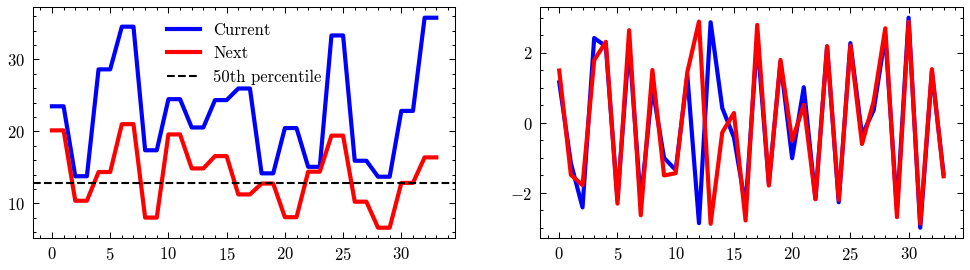

In [236]:
thresholded_soi = np.abs(cur_soi) > np.quantile(np.abs(cur_soi), cutoff)
fig, ax = plt.subplots(1, 2, figsize=(8,2))

ax[0].plot(np.abs(cur_soi)[thresholded_soi], label='Current', color='blue', linewidth=2)
ax[0].plot(np.abs(next_soi)[thresholded_soi], label='Next', color='red', linestyle='solid', linewidth=2)
ax[0].axhline(y=np.quantile(np.abs(cur_soi), cutoff), linestyle='--', color='k', label=f'{int(cutoff * 100)}th percentile')
ax[0].legend()

# Check profile changes in angle
ax[1].plot(np.angle(cur_soi)[thresholded_soi], label='Current', color='blue', linewidth=2)
ax[1].plot(np.angle(next_soi)[thresholded_soi], label='Next', color='red', linestyle='solid', linewidth=2)

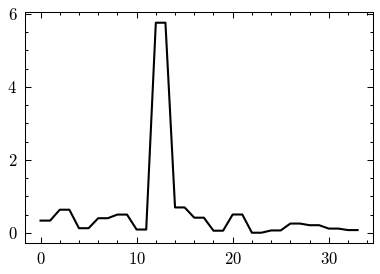

In [237]:
phase_response = np.angle(next_soi)[thresholded_soi] - np.angle(cur_soi)[thresholded_soi]
plt.plot(np.abs(phase_response))

#### PCC strength (frame selection to phase response)

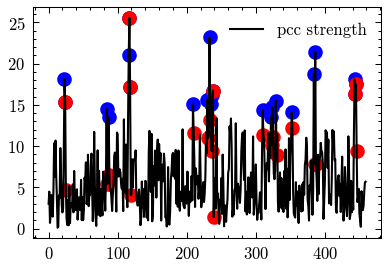

In [238]:
pcc_indexes = np.array([lidx for lidx, label in enumerate(region_labels) if 'posteriorcingulate' in label.lower()])
pcc_strength = np.abs(roi_timecourses)[pcc_indexes].mean(axis=0)

threshold = np.quantile(pcc_strength, 0.95)
above_thresh = np.where(pcc_strength > threshold)[0]

next_indexes = above_thresh + 1
assert next_indexes.max() < nb_time

avg_signal = roi_timecourses[:, above_thresh].mean(axis=1)
avg_signal_next = roi_timecourses[:, next_indexes].mean(axis=1)

plt.plot(pcc_strength, label='pcc strength')
plt.scatter(above_thresh, pcc_strength[above_thresh], color='blue')
plt.scatter(next_indexes, pcc_strength[next_indexes], color='red')
plt.legend()

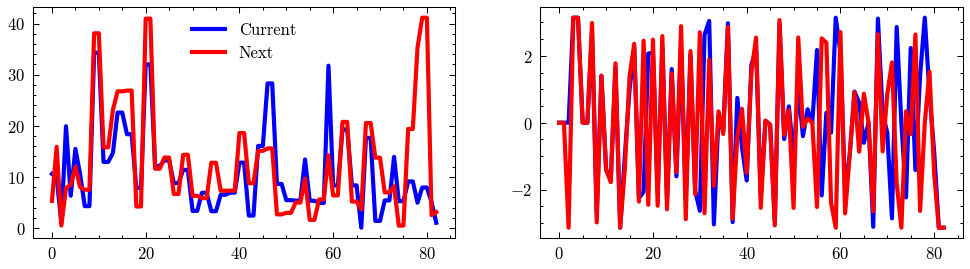

In [239]:
current_spectrum = operations.GFT(avg_signal, U, Uinv=Uinv)
next_spectrum = operations.GFT(avg_signal_next, U, Uinv=Uinv)

# Check profile spectrum amplitude of signal
fig, ax = plt.subplots(1, 2, figsize=(8,2))
ax[0].plot(np.abs(current_spectrum), label='Current', color='blue', linewidth=2)
ax[0].plot(np.abs(next_spectrum), label='Next', color='red', linestyle='solid', linewidth=2)
ax[0].legend()

# Check profile changes in angle
ax[1].plot(np.angle(current_spectrum), label='Current', color='blue', linewidth=2)
ax[1].plot(np.angle(next_spectrum), label='Next', color='red', linestyle='solid', linewidth=2)

In [240]:
cutoff = 0.8
angles_idx = V.imag != 0

cur_soi = deepcopy(current_spectrum)
cur_soi[~angles_idx] = 0
next_soi = deepcopy(next_spectrum)
next_soi[~angles_idx] = 0

thresholded_soi = np.abs(cur_soi) >= (np.quantile(np.abs(cur_soi), cutoff) - 1e-3) # we pad with an epsilon=1e-3 to include all pairs
assert thresholded_soi.sum() % 2 ==0
print(f"number of components in phase profile {np.round(thresholded_soi.sum())}")

number of components in phase profile 18


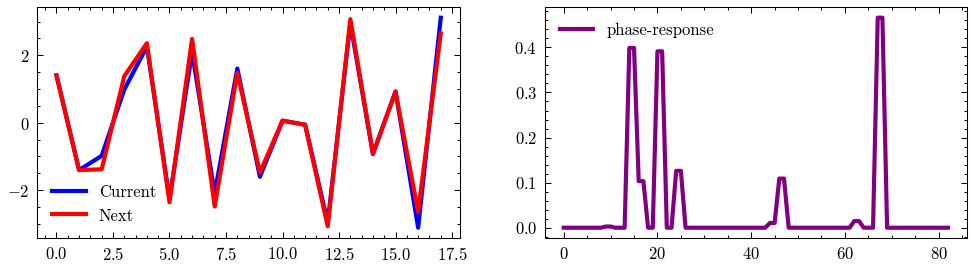

In [241]:
fig, ax = plt.subplots(1, 2, figsize=(8,2))

cur_important_angles = np.zeros_like(current_spectrum)
cur_important_angles[thresholded_soi] = np.angle(current_spectrum)[thresholded_soi]
next_important_angles = np.zeros_like(current_spectrum)
next_important_angles[thresholded_soi] = np.angle(next_spectrum)[thresholded_soi]

ax[0].plot(np.angle(current_spectrum)[thresholded_soi], label='Current', color='blue', linewidth=2)
ax[0].plot(np.angle(next_spectrum)[thresholded_soi], label='Next', color='red', linestyle='solid', linewidth=2)
ax[0].legend()

phase_response = next_important_angles - cur_important_angles
ax[1].plot(np.abs(phase_response), label='phase-response', color='purple', linewidth=2)
ax[1].legend()

In [242]:
# now let's see what happens with a dirac on a given point - applying spatial phase response
dirac = np.zeros(nb_nodes)
dirac[20] = 1.0
dirac[61] = 1.0

importlib.reload(operations)
pcc_phase_shifted = operations.apply_phaseshift(phase=phase_response, signal=dirac, U=U, V=V, Uinv=Uinv)

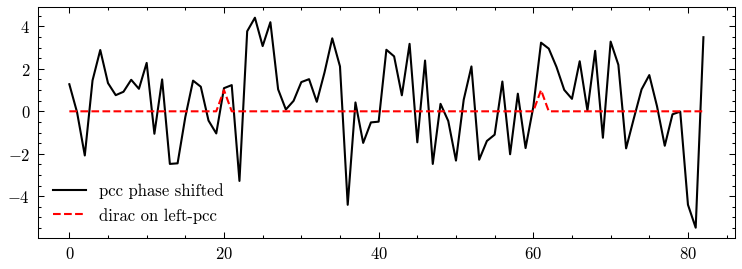

In [243]:
fig, ax = plt.subplots(1, 1, figsize=(6,2)) 
ax.plot(pcc_phase_shifted.real, label='pcc phase shifted')
ax.plot(dirac, label='dirac on left-pcc')
ax.legend()

(<Figure size 3000x2250 with 8 Axes>,
 array([[<Axes3D: >, <Axes3D: >],
        [<Axes3D: >, <Axes3D: >]], dtype=object))

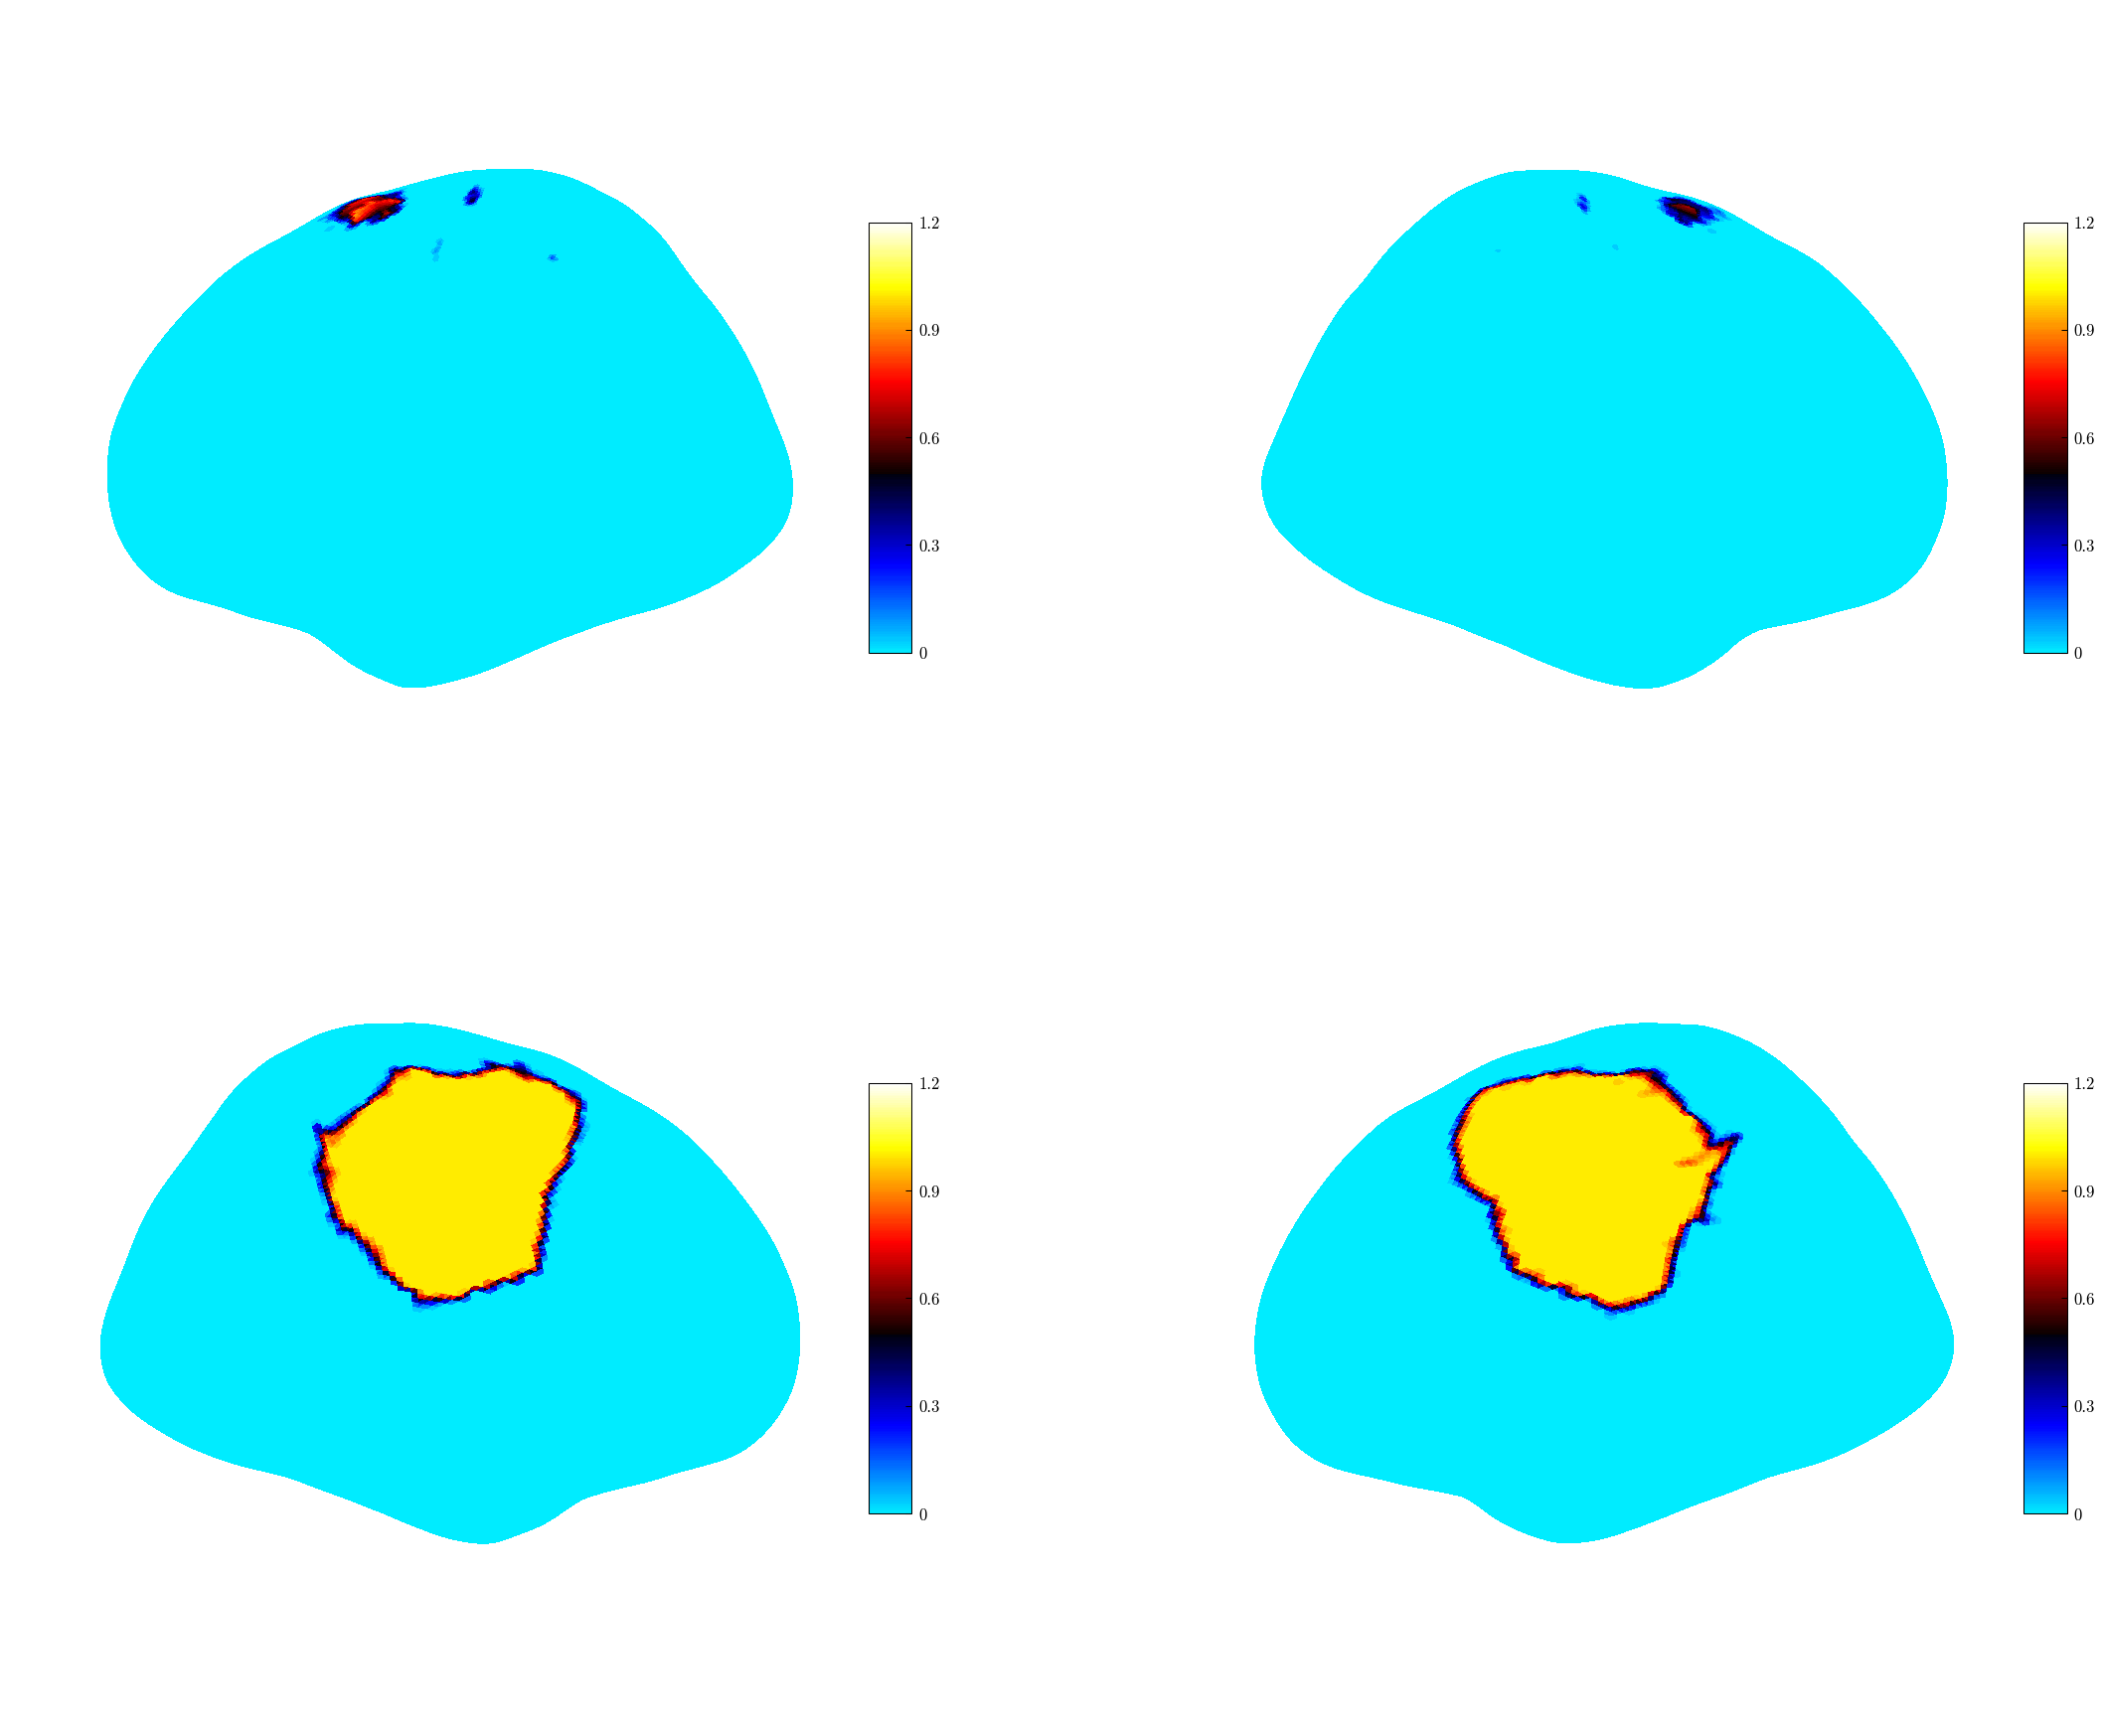

In [244]:
plot_surf.plot_node_signal_on_surf(dirac, roi_atlas, region_labels, vmin=-0.2, vmax=1.2)

(<Figure size 3000x2250 with 8 Axes>,
 array([[<Axes3D: >, <Axes3D: >],
        [<Axes3D: >, <Axes3D: >]], dtype=object))

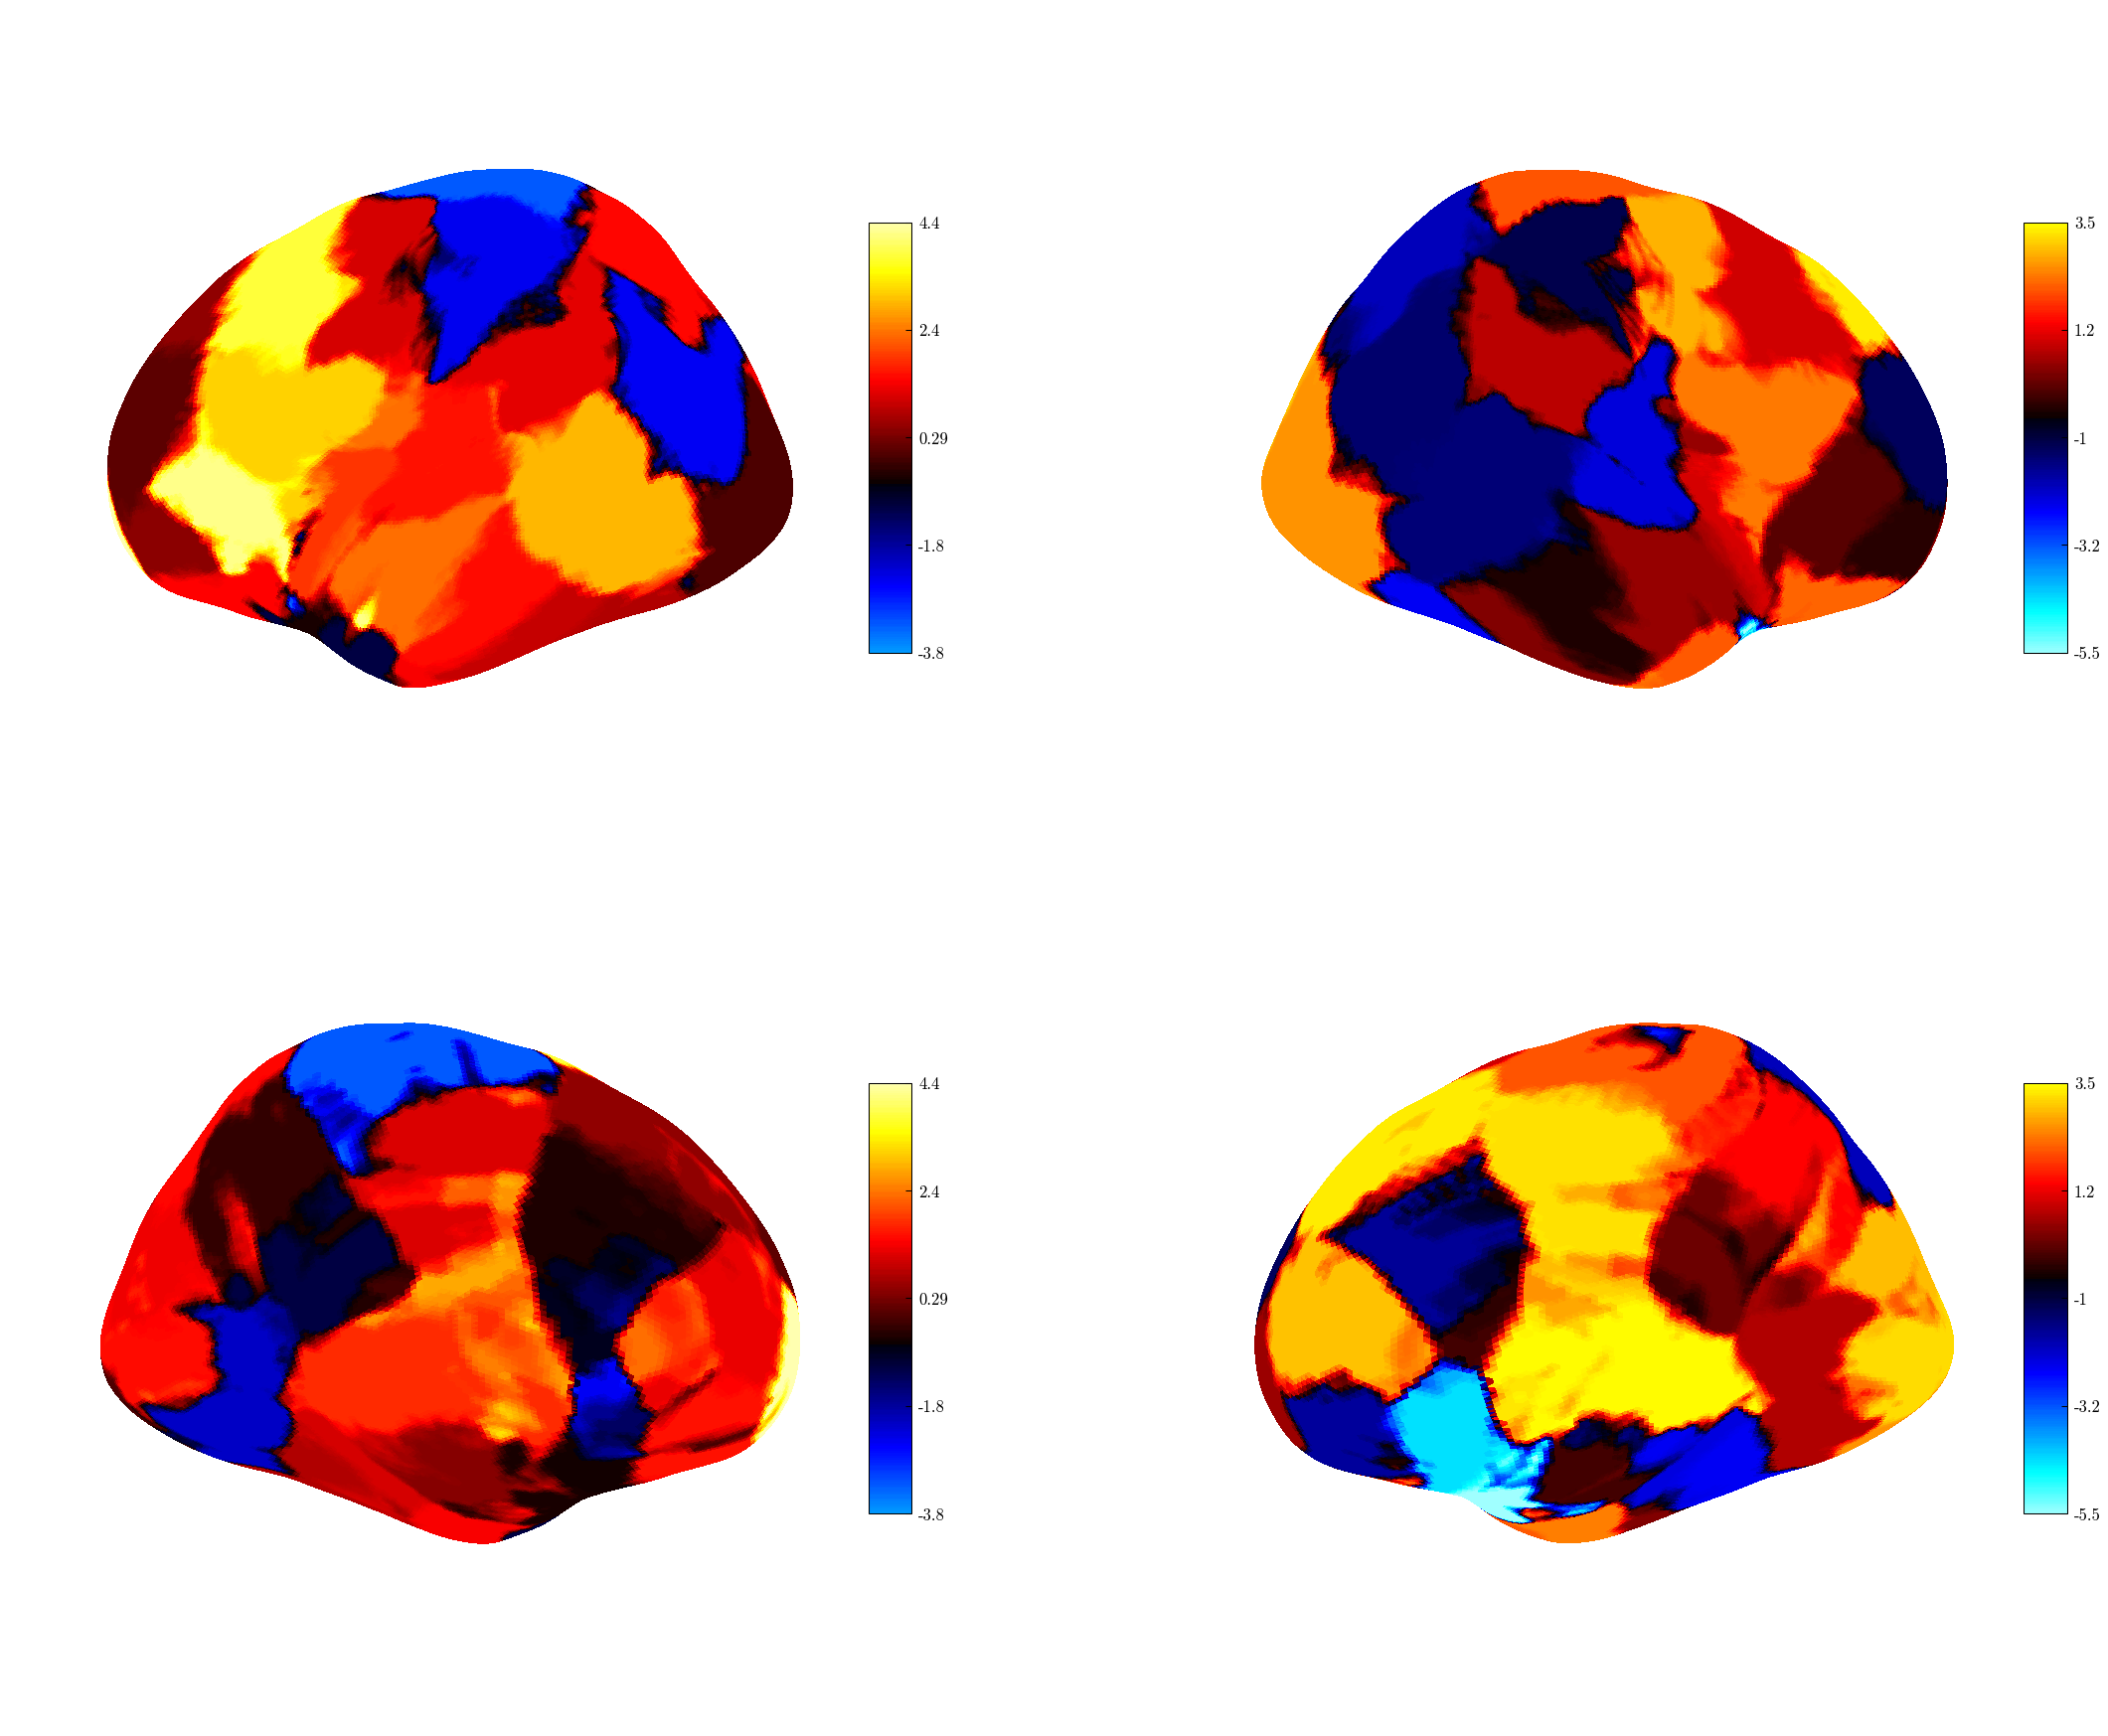

In [245]:
plot_surf.plot_node_signal_on_surf(pcc_phase_shifted.real, roi_atlas, region_labels, 
                                   vmin=pcc_phase_shifted.real.min() * 1.1, 
                                   vmax=pcc_phase_shifted.real.max() * 1.1)